In [1]:
from typing import List, Optional

import cv2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from jh1.visual import instantiate_detector, find_april_tags, count_clusters, VariCluster, \
    PIECE_TAG_IDS, \
    HomographySolver
from jh1.visual._homography_solver import GRID_SIZE
from jh1.visual.video import WebcamSource


In [2]:
cam = WebcamSource(cam_id=0)

In [3]:
img = cam.read_frame()

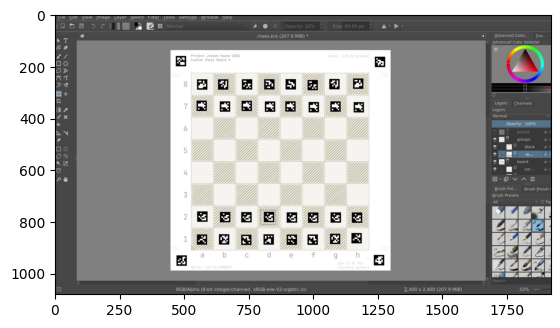

In [4]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

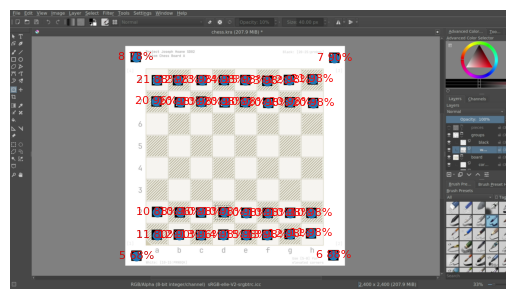

In [6]:
detector = instantiate_detector()
detections = find_april_tags(img, detector)
clusters: List[VariCluster] = count_clusters(detections)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
xs = []
ys = []
for cluster in clusters:
    text = f"{cluster.tag_id} {cluster.detection_count / 50:.0%}"
    x, y = cluster.position
    xs.append(x)
    ys.append(y)
    color_intensity = 100 + (cluster.detection_count / 50) * 150
    color = (color_intensity / 255, 10 / 255, 10 / 255)  # Normalize RGB to 0–1 range
    plt.text(x, y, text, fontsize=8, color=color, ha='center', va='center')

plt.scatter(xs, ys)

plt.axis('off')
plt.show()

In [7]:
corners_tags: List[Optional[VariCluster]] = [None] * 4
pieces_tags: List[VariCluster] = []

for cluster in clusters:
    print(cluster.tag_id)
    if cluster.is_piece_tag():
        pieces_tags.append(cluster)
    elif cluster.get_vert_idx_if_corner() is not None:
        corners_tags[cluster.get_vert_idx_if_corner()] = cluster

6
7
8
10
10
10
10
10
10
10
10
11
11
12
12
13
13
14
15
20
20
20
20
20
20
20
20
21
21
22
22
23
23
24
25
5


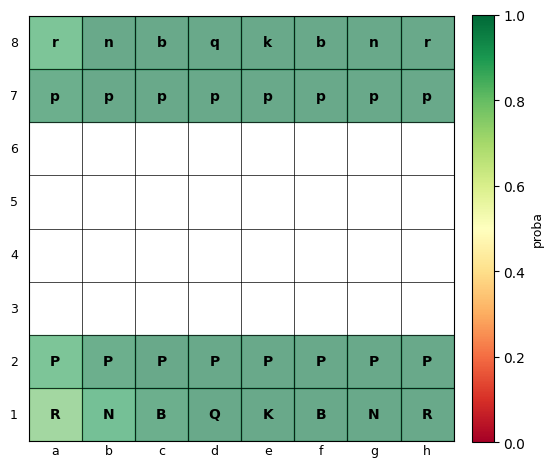

In [8]:
solver = HomographySolver(corners_tags)
board_bins = solver.bin_pieces(pieces_tags)
certainty_grid = HomographySolver.get_certainty_grid(board_bins)

cmap = mpl.colormaps.get_cmap('RdYlGn')
norm = mpl.colors.Normalize(vmin=0, vmax=1)

files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
ranks = ['1', '2', '3', '4', '5', '6', '7', '8']

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_aspect('equal')
ax.invert_yaxis()

# Draw grid
for i in range(9):
    ax.axhline(i, color='black', linewidth=0.5)
    ax.axvline(i, color='black', linewidth=0.5)

# Annotate files and ranks
for i in range(8):
    ax.text(i + 0.5, 8.3, files[i], ha='center', va='bottom', fontsize=9)
    ax.text(-0.2, 7 - i + 0.5, ranks[i], ha='right', va='center', fontsize=9)

# Draw pieces and certainty overlay
for i in range(8):
    for j in range(8):
        certainty = certainty_grid[i, j]
        if certainty > 0:
            color = cmap(norm(certainty))
            ax.add_patch(plt.Rectangle((j, 7 - i), 1, 1, color=color, alpha=0.6))

        bin_tags = board_bins[i][j]
        if bin_tags:
            labels = [PIECE_TAG_IDS.get(t.tag_id, str(t.tag_id)) for t in bin_tags]
            text = ", ".join(labels)
            ax.text(j + 0.5, 7 - i + 0.5, text, ha='center', va='center', fontsize=10,
                    weight='bold')

# Add colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('proba', fontsize=9)

plt.xticks([])
plt.yticks([])
plt.show()


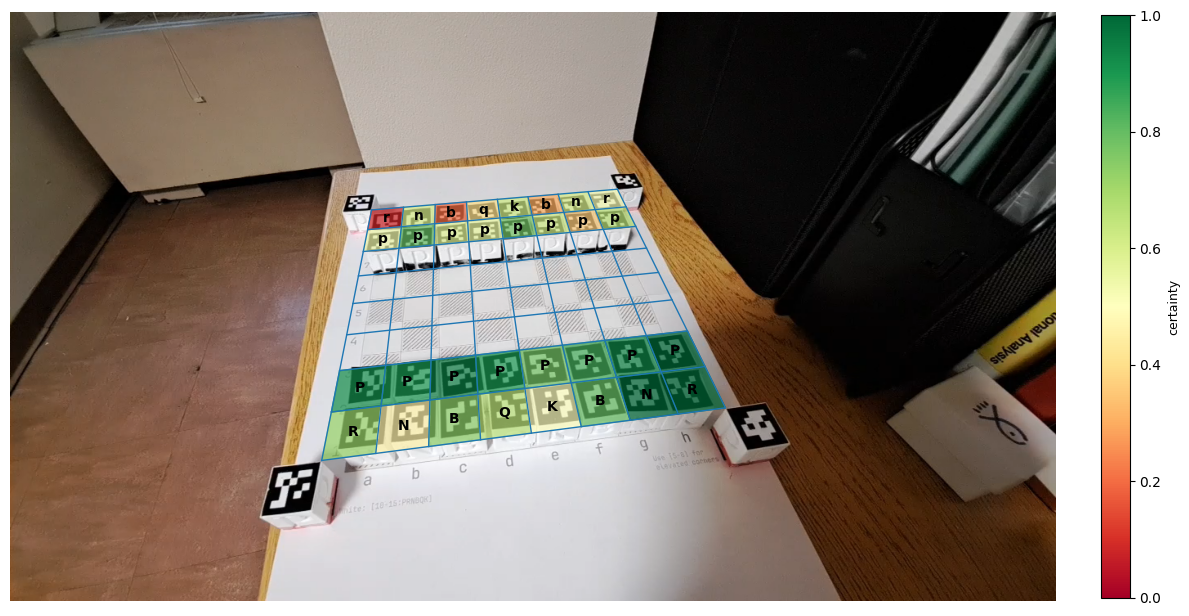

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


def project_board_to_img(pt):
    pt = np.array(pt, dtype=np.float32)
    if solver.adjust:
        center = np.array([5, 5], dtype=np.float32)
        pt = (pt - center) * (9 / 8) + center
    vec = np.array([pt[0], pt[1], 1.0])
    img_pt_h = np.linalg.inv(solver.mat_homography) @ vec
    img_pt = img_pt_h[:2] / img_pt_h[2]
    return tuple(img_pt)


# Draw projected 8x8 grid lines (board coordinates from 1 to 9)
for i in range(9):
    # Vertical lines (x = i + 1)
    p1 = project_board_to_img((i + 1, 1))
    p2 = project_board_to_img((i + 1, 9))
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='tab:blue', linewidth=1)

    # Horizontal lines (y = i + 1)
    p3 = project_board_to_img((1, i + 1))
    p4 = project_board_to_img((9, i + 1))
    ax.plot([p3[0], p4[0]], [p3[1], p4[1]], color='tab:blue', linewidth=1)

# Draw 8x8 grid cell certainty overlays and piece labels
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        # Four corners of the square in board space
        corners = [
            (j + 1, i + 1),
            (j + 2, i + 1),
            (j + 2, i + 2),
            (j + 1, i + 2),
        ]
        img_corners = [project_board_to_img(c) for c in corners]

        certainty = certainty_grid[i, j]
        if certainty > 0:
            poly = plt.Polygon(img_corners, color=cmap(norm(certainty)), alpha=0.7)
            ax.add_patch(poly)

        bin_tags = board_bins[i][j]
        if bin_tags:
            labels = [PIECE_TAG_IDS.get(t.tag_id, str(t.tag_id)) for t in bin_tags]
            label_text = ", ".join(labels)

            # Center of the square
            center_pt = project_board_to_img((j + 1.5, i + 1.5))
            ax.text(
                center_pt[0], center_pt[1], label_text,
                fontsize=10, ha='center', va='center', weight='bold',
                color="black"
            )

# Add colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.026, pad=0.04)
cbar.set_label('certainty', fontsize=9)

ax.axis('off')
plt.tight_layout()
plt.show()
